# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [10]:
import re
import torch

########## YOUR SOLUTION HERE ##########
class Encoder:
    def __init__(self, input_alphabet):
        self.alphabet = input_alphabet
    def __call__(self, input_string):
        encoded_string = []
        for character in input_string:
            for i in range(len(self.alphabet)):
                if character == self.alphabet[i]:
                    encoded_string.append(i)
                    break
        return torch.tensor(encoded_string)
    
encoder = Encoder("abcdefghijklmnopqrstuvwxyz0123456789 .!?")
print(encoder("cat"))

tensor([ 2,  0, 19])


## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [11]:
import torch
from torch.utils.data import Dataset

########## YOUR SOLUTION HERE ##########
class TextDataset(Dataset):
    def __init__(self, path, l):
        self.l = l
        with open(path, 'rb') as f:
            self.text = f.read().decode('utf-8')

        self.text = encoder(self.text)
        
    def __len__(self):
        return len(self.text) // self.l

    def __getitem__(self, idx):
        start = idx * self.l
        end = start + self.l
        input_sequence = self.text[start:end]
        target_sequence = self.text[start+1:end+1]
        return input_sequence, target_sequence

In [12]:
txtDtst = TextDataset('trump_train.txt', 3)

print(txtDtst.__len__())
print(txtDtst.__getitem__(1))

261360
(tensor([37, 37,  7]), tensor([37,  7,  0]))


## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class NextCharLSTM(torch.nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, hidden_dim: int):
        super().__init__()
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
        self.output = torch.nn.Linear(hidden_dim, alphabet_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.output(x)
        return x


# Instantiate the model
model = NextCharLSTM(alphabet_size=len(encoder.alphabet), embedding_dim=64, hidden_dim=128)

# Set the model to training mode
model.train()

# Generate some random input sequences
input_sequences = torch.randint(0, len(encoder.alphabet), size=(5, 10))

# Pass the input sequences through the model
logits = model(input_sequences)
print(logits)

tensor([[[-0.0111,  0.1432,  0.1305,  ..., -0.1270, -0.1321,  0.0114],
         [ 0.0761,  0.1362,  0.0916,  ..., -0.1019, -0.1346, -0.0053],
         [ 0.0350, -0.0458,  0.0466,  ..., -0.1097, -0.1598,  0.0380],
         ...,
         [ 0.0170,  0.1493,  0.0310,  ..., -0.0844, -0.0156, -0.1121],
         [ 0.0591,  0.1206, -0.0519,  ..., -0.0829, -0.0140, -0.0980],
         [ 0.1148,  0.1310, -0.0708,  ..., -0.0465, -0.0730, -0.0535]],

        [[-0.0188,  0.0160,  0.0007,  ..., -0.0507, -0.0453, -0.0680],
         [ 0.0243, -0.0557, -0.0454,  ..., -0.0464, -0.1351, -0.0468],
         [ 0.0594,  0.0649, -0.0187,  ..., -0.0756, -0.0786, -0.0540],
         ...,
         [ 0.1241,  0.0643, -0.1378,  ...,  0.0110, -0.0363, -0.0672],
         [ 0.0550,  0.0665,  0.0573,  ...,  0.0718, -0.0475, -0.0925],
         [ 0.0962,  0.0513, -0.0583,  ..., -0.0211, -0.0371, -0.0666]],

        [[ 0.0864,  0.0542,  0.0571,  ...,  0.0235, -0.0980, -0.0838],
         [ 0.0463, -0.0669,  0.0100,  ..., -0

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [33]:
from torch.utils.data import DataLoader
import numpy as np

########## YOUR SOLUTION HERE ##########
def epoch(dataloader, model, optimizer=None):
    if optimizer is not None:
        model.train()
    else:
        model.eval()
    
    loss_fn = torch.nn.CrossEntropyLoss()
    
    losses = []
    
    for input_sequences, target_sequences in dataloader:

        logits = model(input_sequences)
        logits = torch.moveaxis(logits, 1, 2)
        
        loss = loss_fn(logits, target_sequences)
        
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
    
    return np.array(losses)

encoder = Encoder('abcdefghijklmnopqrstuvwxyz0123456789 .!?')


train_data = TextDataset(r"trump_train.txt", 99)
val_data = TextDataset(r"trump_val.txt", 99)


train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data,  batch_size=256, shuffle=False)

model = NextCharLSTM(alphabet_size=len(encoder.alphabet), embedding_dim=8, hidden_dim=512)
optimizer = torch.optim.Adam(model.parameters())

train_losses = epoch(train_dataloader, model, optimizer)
val_losses = epoch(val_dataloader, model)

print(np.mean(train_losses))
print(np.mean(val_losses))

3.0749623698572957
2.8823511600494385


## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

In [35]:
import matplotlib.pyplot as plt

sequence_length = 99
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 30

train_losses = []
val_losses = []

best_val_loss = float('inf')


encoder = Encoder('abcdefghijklmnopqrstuvwxyz0123456789 .!?')

train_data = TextDataset(r"trump_train.txt", l = sequence_length)
val_data = TextDataset(r"trump_val.txt", l = sequence_length )

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = torch.utils.data.DataLoader(train_data,  batch_size = batch_size)

val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

model = NextCharLSTM(alphabet_size=len(encoder.alphabet), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters())


for epoch_number in range(num_epochs):
    print(epoch_number)
    train_loss = epoch(train_dataloader, model, optimizer)
    val_loss = epoch(val_dataloader, model)
    
    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    print(val_losses[-1])
    if val_losses[-1] < best_val_loss:
        torch.save(model, 'best_model.pt')
        best_val_loss = val_losses[-1]

0
2.8698036670684814
1
2.7747950553894043
2
2.6839354038238525
3
2.615642547607422
4
2.5477678775787354
5
2.473287582397461
6
2.396364450454712
7
2.311138391494751
8
2.2392098903656006
9
2.164372444152832
10
2.094559907913208
11
2.029189109802246
12
1.9696193933486938
13
1.915152907371521
14
1.8650891780853271
15
1.8166755437850952
16
1.7745659351348877
17
1.7379021644592285
18
1.7017658948898315
19
1.670096516609192
20
1.64361572265625
21
1.6189589500427246
22
1.5960228443145752
23
1.5741592645645142
24
1.554239273071289
25
1.535888910293579
26
1.5209108591079712
27
1.5060617923736572
28
1.493007779121399
29
1.4831839799880981


## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

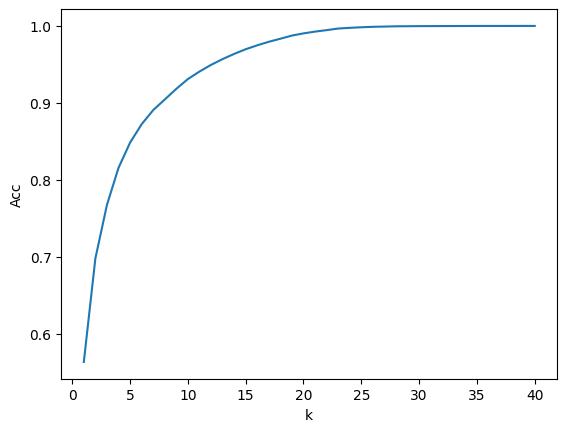

In [36]:
def topk_accuracy(k, model, dataloader):
  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
    for input_sequences, target_sequences in dataloader:
        logits = model(input_sequences)
        _, topk = logits.topk(k, dim=2)
        correct += topk.eq(target_sequences.unsqueeze(-1)).sum().item()
        total += target_sequences.numel()

  return correct / total

model = torch.load("best_model.pt")
encoder = Encoder('abcdefghijklmnopqrstuvwxyz0123456789 .!?')
val_data = TextDataset(r"trump_val.txt", sequence_length)
test_dataloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
k_values = range(1, len(encoder.alphabet) + 1)
accuracies = [topk_accuracy(k, model, test_dataloader) for k in k_values]

plt.plot(k_values, accuracies)
plt.xlabel("k")
plt.ylabel("Acc")
plt.show()

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size. 

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by 
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0 
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable 
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best. 

In [ ]:
########## YOUR SOLUTION HERE ##########

from torch.distributions import Gumbel 

encoder = Encoder('abcdefghijklmnopqrstuvwxyz0123456789 .!?')

val_data = TextDataset(r"trump_val.txt", l = sequence_length)
test_dataloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

model = torch.load("best_model.pt")
model.eval()

def sample_next_char(logits, temperature):
    pi = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature))
    
    gumbel_dist = Gumbel(torch.zeros_like(logits), torch.ones_like(logits))
    gumbel_samples = gumbel_dist.sample()
    
    y = torch.argmax(logits / temperature + gumbel_samples, dim=-1)
    
    return y

encoder = Encoder('abcdefghijklmnopqrstuvwxyz0123456789 .!?')

val_data = TextDataset(r"trump_train.txt", l = 5)

test_dataloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)



model = torch.load("best_model.pt")
model.eval()

for temperature in [0.1, 0.2, 0.3, 0.5, 1.0]:
    for input_sequences, _ in test_dataloader:
        logits = model(input_sequences)
        y = sample_next_char(logits, temperature)
        generated_chars = [encoder(char_idx) for char_idx in y]
        print("Temperature: ",temperature)

      

## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers. 

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set. 
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature? 

In [ ]:
from heapq import heapify, heappop, heappush

def huffman_code(freqs):
    """This function turns a list of frequencies into a Huffman code. """
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [''] * len(freqs)
    
    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))
        
        for i in idx0:
            code[i] = '0' + code[i]
        
        for i in idx1:
            code[i] = '1' + code[i]
    
    return code

########## YOUR SOLUTION HERE ##########